## 1. Import the required packages

In [21]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline


## 2. View the pre-defined model
you can download from [here](https://s3.amazonaws.com/cadl/models/vgg16.tfmodel). Please remember its a 550MB file.

In [22]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pre-trained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_8:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_9:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75

## 3. View the content image

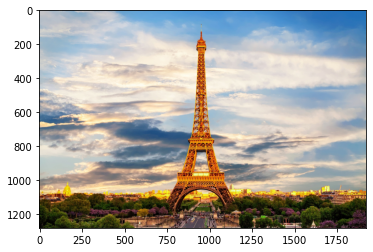

In [23]:
content_image = imageio.imread("images/eiffel-tower.jpg")
imshow(content_image);

## 4. Compute the content cost

Content cost is computed on a selected layer **l** from the seleted neural network. This layer **l** is usually neither too shallow nor too deep in the network. Its somewhere in the middle.

In [24]:
def compute_content_cost(a_C, a_G):
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C,shape = [m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape = [m,-1,n_C])
    # compute the cost with tensorflow
    J_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))
    return J_content

## 5. View Style image

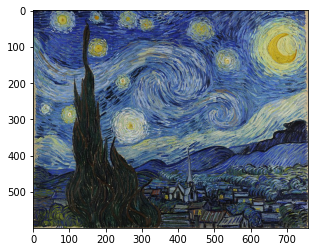

In [25]:
style_image = imageio.imread("images/starry_night.jpg")
imshow(style_image);

## 6. Create the Gram matrix

In [26]:
def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    return GA

## 7. Compute the single layer style cost

In [27]:
def compute_layer_style_cost(a_S, a_G):
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(tf.transpose(a_S,perm=[0,3,1,2]),shape=[n_C,-1])
    a_G = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),shape=[n_C,-1])
    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    # Computing the loss 
    J_style_layer =(1/(4*(n_C**2)*(n_H*n_W)**2))*(tf.reduce_sum(tf.square(tf.subtract(GS,GG))))
    
    return J_style_layer

## 8. Compute multi layer style cost

Unlike **Content Cost** style cost is computed on all layers. This imporves the quality of the syle in the genreaated image.

In [28]:
STYLE_LAYERS = [
    ('conv1_1', 0.18),
    ('conv2_1', 0.2),
    ('conv3_1', 0.22),
    ('conv4_1', 0.22),
    ('conv5_1', 0.18)]

In [29]:
def compute_style_cost(model, STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        # Select the output tensor of the currently selected layer
        out = model[layer_name]
        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)
        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

## 9. comput the total cost functon

In [30]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content+beta*J_style
    return J

In [31]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

## 10. Load the content image
Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [32]:
content_image = imageio.imread("images/eiffel-tower_resized.jpg")
content_image = reshape_and_normalize_image(content_image)

## 11. Load the style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [33]:
style_image =imageio.imread("images/starry_night_resized.jpg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


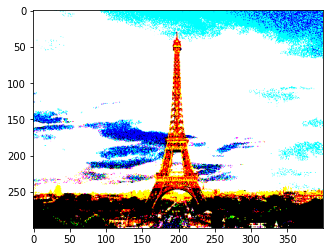

In [34]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

## 12.  Load pre-trained VGG19 model

In [35]:
model = load_vgg_model("pre-trained-model/imagenet-vgg-verydeep-19.mat")

#### Content Cost

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost.

In [36]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [37]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

#### Total cost

In [38]:
J = total_cost(J_content,J_style,10,40)

#### Optimizer

* Adam optimize is used to minimize total cost (J).
* learning rate used is 2.0.  

In [39]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

## 13. Define the model

In [40]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

## 14. Run the model

In [41]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5885977000.0
content cost = 10615.004
style cost = 147146780.0
Iteration 20 :
total cost = 734845440.0
content cost = 18370.436
style cost = 18366544.0
Iteration 40 :
total cost = 284795070.0
content cost = 19862.982
style cost = 7114911.5
Iteration 60 :
total cost = 173737760.0
content cost = 20690.82
style cost = 4338271.0
Iteration 80 :
total cost = 126334090.0
content cost = 21197.262
style cost = 3153052.8
Iteration 100 :
total cost = 99512110.0
content cost = 21570.066
style cost = 2482410.2
Iteration 120 :
total cost = 81922460.0
content cost = 21909.508
style cost = 2042584.1
Iteration 140 :
total cost = 69402344.0
content cost = 22217.562
style cost = 1729504.1
Iteration 160 :
total cost = 60091652.0
content cost = 22494.635
style cost = 1496667.6
Iteration 180 :
total cost = 52938028.0
content cost = 22738.79
style cost = 1317766.0


array([[[[  67.24492  ,   36.232327 ,   30.266659 ],
         [  19.170763 ,   15.022406 ,   20.438498 ],
         [   5.995662 ,   11.979976 ,   22.934116 ],
         ...,
         [  -2.6173806,   75.85165  ,   16.459633 ],
         [ -50.607857 ,   18.315956 ,    6.6711507],
         [  18.110092 ,   62.46784  ,   45.23048  ]],

        [[  30.80136  ,   66.24524  ,   22.403826 ],
         [  24.559536 ,   51.541348 ,   12.766437 ],
         [  33.958294 ,   73.58556  ,   14.267927 ],
         ...,
         [  -4.452222 ,   43.929146 ,   86.730576 ],
         [  -5.073131 ,   37.52334  ,   68.50223  ],
         [  11.438985 ,   49.90694  ,   87.28556  ]],

        [[  51.69581  ,   86.11042  ,   32.347393 ],
         [  44.412083 ,   66.42047  ,   40.854298 ],
         [  51.13826  ,   51.226673 ,   64.48189  ],
         ...,
         [-119.71835  ,  -83.66141  ,   -9.079214 ],
         [-107.27669  ,  -68.30362  ,  -14.351076 ],
         [  13.42174  ,   48.231995 ,  117.0616   ]],

## 15. View generated output

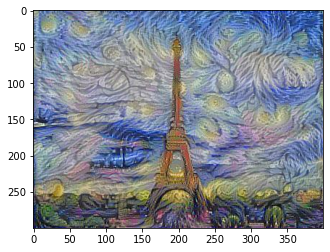

In [42]:
generated_image = imageio.imread("output/generated_image.jpg")
imshow(generated_image);

This is pretty darn good.

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
- Deep learning Specialization from coursera